# PyTorch Training

* [PyTorch: Tensors and autograd](https://pytorch.org/tutorials/beginner/pytorch_with_examples.html#autograd)

The autograd package in PyTorch uses [automatic differentiation](https://en.wikipedia.org/wiki/Automatic_differentiation) to automate the computation of backward passes. 

1. Define a computational graph at the forward pass. Nodes in the graph will be Tensors, and edges will be functions that produce output Tensors from input Tensors. Note that ```tensor.requires_grad=True``` is required to apply autograd to a tensor.
2. ```loss.backward()``` back-propagates through the graph to compute gradients. Then ```tensor.grad``` has the gradient computed for the tensor.



In [1]:
import torch
import math
import matplotlib.pyplot as plt

In [2]:
dtype = torch.float
device = "cuda" if torch.cuda.is_available() else "cpu"
torch.set_default_device(device)

--- 
# Native Training Implementation

## Target to approximate

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


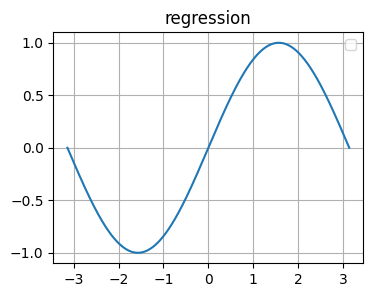

In [3]:
# Create Tensors to hold input and outputs.
# By default, requires_grad=False, which indicates that we do not need to
# compute gradients with respect to these Tensors during the backward pass.
x = torch.linspace(-math.pi, math.pi, 2000, dtype=dtype)
y = torch.sin(x)

plt.figure(figsize=(4,3))
plt.plot(x.cpu(), y.cpu())
plt.title("regression")

plt.legend()
plt.grid()

## Model parameters

In [4]:
# Create random Tensors for weights. For a third order polynomial, we need
# 4 weights: y = a + b x + c x^2 + d x^3
# Setting requires_grad=True indicates that we want to compute gradients with
# respect to these Tensors during the backward pass.
a = torch.randn((), dtype=dtype, requires_grad=True)
b = torch.randn((), dtype=dtype, requires_grad=True)
c = torch.randn((), dtype=dtype, requires_grad=True)
d = torch.randn((), dtype=dtype, requires_grad=True)

## Training to fit parameters

In [5]:
learning_rate = 1e-6
for t in range(2000):
    # Forward pass: compute predicted y using operations on Tensors.
    y_pred = a + b * x + c * x ** 2 + d * x ** 3

    # Compute and print loss using operations on Tensors.
    # Now loss is a Tensor of shape (1,)
    # loss.item() gets the scalar value held in the loss.
    loss = (y_pred - y).pow(2).sum()
    if t % 100 == 99:
        print(t, loss.item())

    # Use autograd to compute the backward pass. This call will compute the
    # gradient of loss with respect to all Tensors with requires_grad=True.
    # After this call a.grad, b.grad. c.grad and d.grad will be Tensors holding
    # the gradient of the loss with respect to a, b, c, d respectively.
    loss.backward()

    # Manually update weights using gradient descent. Wrap in torch.no_grad()
    # because weights have requires_grad=True, but we don't need to track this
    # in autograd.
    with torch.no_grad():
        a -= learning_rate * a.grad
        b -= learning_rate * b.grad
        c -= learning_rate * c.grad
        d -= learning_rate * d.grad

        # Manually zero the gradients after updating weights
        a.grad = None
        b.grad = None
        c.grad = None
        d.grad = None

print(f'Result: y = {a.item()} + {b.item()} x + {c.item()} x^2 + {d.item()} x^3')

99 2661.3759765625
199 1764.515869140625
299 1170.9716796875
399 778.1401977539062
499 518.13232421875
599 346.02667236328125
699 232.09739685058594
799 156.6739501953125
899 106.73811340332031
999 73.67387390136719
1099 51.779029846191406
1199 37.27892303466797
1299 27.67525863647461
1399 21.3138484954834
1499 17.099491119384766
1599 14.307201385498047
1699 12.45689868927002
1799 11.230644226074219
1899 10.417810440063477
1999 9.878945350646973
Result: y = 0.007568386383354664 + 0.8258374333381653 x + -0.0013056716416031122 x^2 + -0.08893465250730515 x^3


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


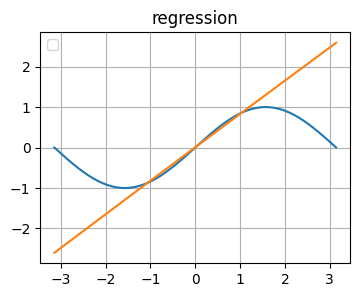

In [6]:
ahat = a.item()
bhat = b.item()
chat = c.item()
dhat = d.item()

x = x.cpu().numpy()
y = y.cpu().numpy()
yhat = ahat + bhat * x + chat * x**2 + dhat**3

plt.figure(figsize=(4,3))
plt.plot(x, y)
plt.plot(x, yhat)
plt.title("regression")

plt.legend()
plt.grid()

---
# nn.module

Pytorch ```nn.Module``` is equivalent to Keras in TensorFlow which provides higher-level abstractions over raw computational graphs to build a neural network.

A ```Module``` receives input Tensors to compute output Tensors, and holds internal state such as Tensors containing learnable ```Parameters```. 

## Parameters

Torch Parameters are variables of a module to memorize the model state, hence they are learnable parameters and ```requires_grad``` is **True** by default.

## Optimizer

Gradient descent/update is handled by the ```torch.optim``` class.

For SGD, the native calculation:
```
# Update the weights using gradient descent. Each parameter is a Tensor, so
# we can access its gradients like we did before.
with torch.no_grad():
    for param in model.parameters():
        param -= learning_rate * param.grad
```

This is replaced with:
```
optimizer = torch.optim.SGD(model.parameters(), lr=1e-6)
for epoch in range(2000):
    y_pred = model(x)
    loss = loss_fn(y_pred, y)

    # Zero gradients, perform a backward pass, and update the weights.
    optimizer.zero_grad()   (need zero_grad() for correct gradient update)
    loss.backward()
    optimizer.step()        <-----
```

### Why ```optimizer.zero_grad()``` 

It is due to PyTorch default behavior of accumulating gradients.

* [Why do we need to call zero_grad() in PyTorch?](https://stackoverflow.com/a/48009142)

> By default, PyTorch accumulates the gradients on subsequent backward passes. It is an essential feature when the model or input data is big and one training batch does not fit on the GPU. See [Resolving CUDA Being Out of Memory With Gradient Accumulation and AMP](https://towardsdatascience.com/i-am-so-done-with-cuda-out-of-memory-c62f42947dca) and PyTorch default action has been set to accumulate (i.e. sum) the gradients on every ```loss.backward()``` call.
> 
> Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly. **Otherwise, the gradient would be a combination of the old gradient**, which you have already used to update your model parameters

* [Resolving CUDA Being Out of Memory With Gradient Accumulation and AMP](https://towardsdatascience.com/i-am-so-done-with-cuda-out-of-memory-c62f42947dca)

> Implementing gradient accumulation and automatic mixed precision to solve CUDA out of memory issue when training big deep learning models which requires high batch and input sizes


If all the model and data fit to the GPU memory, we need to discard the old gradients by ```optimizer.zero_grad()``` at every mini-batch (each step in an epoch) during the training phase. So that we use **the gradient from the loss at the current step only**, NOT the mixed with old gradients at previous steps.



 

## nn.Module training implementation

* [](https://pytorch.org/tutorials/beginner/pytorch_with_examples.html)

In [7]:
class Polynomial3(torch.nn.Module):
    def __init__(self):
        """
        In the constructor we instantiate four parameters and assign them as
        member parameters.
        """
        super().__init__()
        
        # The nn.Module implicitly calls requires_grad=True.
        self.a = torch.nn.Parameter(torch.randn(()))
        self.b = torch.nn.Parameter(torch.randn(()))
        self.c = torch.nn.Parameter(torch.randn(()))
        self.d = torch.nn.Parameter(torch.randn(()))

    def forward(self, x):
        """
        In the forward function we accept a Tensor of input data and we must return
        a Tensor of output data. We can use Modules defined in the constructor as
        well as arbitrary operators on Tensors.
        """
        return self.a + self.b * x + self.c * x ** 2 + self.d * x ** 3

    def string(self):
        """
        Just like any class in Python, you can also define custom method on PyTorch modules
        """
        return f'y = {self.a.item()} + {self.b.item()} x + {self.c.item()} x^2 + {self.d.item()} x^3'


# Create Tensors to hold input and outputs.
x = torch.linspace(-math.pi, math.pi, 2000)
y = torch.sin(x)

# Construct our model by instantiating the class defined above
model = Polynomial3()

# Construct our loss function and an Optimizer. The call to model.parameters()
# in the SGD constructor will contain the learnable parameters (defined 
# with torch.nn.Parameter) which are members of the model.
loss_fn = torch.nn.MSELoss(reduction='sum')
optimizer = torch.optim.SGD(model.parameters(), lr=1e-6)
for t in range(2000):
    # Forward pass: Compute predicted y by passing x to the model
    y_pred = model(x)

    # Compute and print loss
    loss = loss_fn(y_pred, y)
    if t % 100 == 99:
        print(t, loss.item())

    # Zero gradients, perform a backward pass, and update the weights.
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

print(f'Result: {model.string()}')

99 1131.777587890625
199 775.6531982421875
299 533.0687255859375
399 367.6368408203125
499 254.6904296875
599 177.4894256591797
699 124.66022491455078
799 88.46739196777344
899 63.64352798461914
999 46.59791564941406
1099 34.88019943237305
1199 26.815975189208984
1299 21.25995635986328
1399 17.4278564453125
1499 14.781947135925293
1599 12.953125
1699 11.687749862670898
1799 10.811365127563477
1899 10.203778266906738
1999 9.782151222229004
Result: y = 0.02866288647055626 + 0.8419437408447266 x + -0.004944825079292059 x^2 + -0.09122563153505325 x^3


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


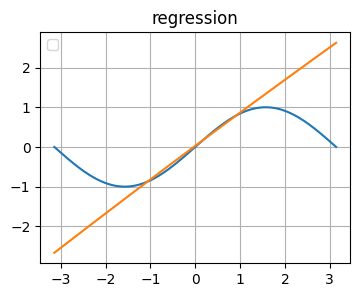

In [8]:
ahat = model.a.item()
bhat = model.b.item()
chat = model.c.item()
dhat = model.d.item()

x = x.cpu().numpy()
y = y.cpu().numpy()
yhat = ahat + bhat * x + chat * x**2 + dhat**3

plt.figure(figsize=(4,3))
plt.plot(x, y)
plt.plot(x, yhat)
plt.title("regression")

plt.legend()
plt.grid()